In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.transforms as mtransforms

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


In [27]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

# General data input

In [28]:
# load  dataset
df_MAHI = pd.read_csv('/home/francovm/Projects/SSE/data/processed/MAHI.csv', sep='\t', encoding='utf-8')
df_PARI = pd.read_csv('/home/francovm/Projects/SSE/data/processed/PARI.csv', sep='\t', encoding='utf-8')
df_MAKO = pd.read_csv('/home/francovm/Projects/SSE/data/processed/MAKO.csv', sep='\t', encoding='utf-8')
df_GISB = pd.read_csv('/home/francovm/Projects/SSE/data/processed/GISB.csv', sep='\t', encoding='utf-8')

df_GISB= df_GISB.drop(df_GISB.columns[[1, 3, 5]], axis=1)
df_GISB.head()

,x,n,u,Events
0,-16.61,-159.10,25.17,1.0
1,-14.99,-158.86,22.46,1.0
2,-15.46,-160.53,22.91,1.0
3,-14.62,-159.06,20.10,1.0
4,-14.13,-160.20,16.44,1.0


In [29]:
date_rng = pd.date_range(start='1/1/2018', end='1/08/2018', freq='H')

In [30]:
stations_list = ['MAHI','PARI','MAKO','GISB']

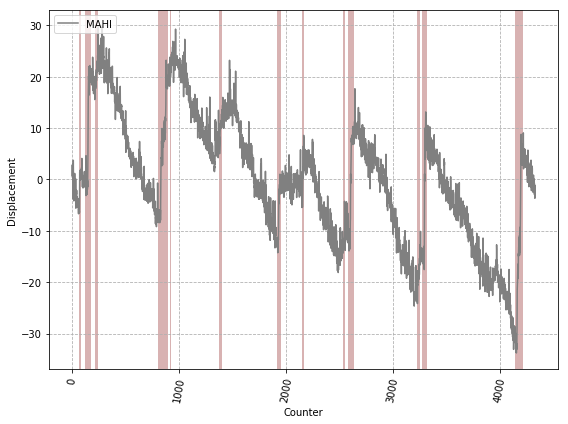

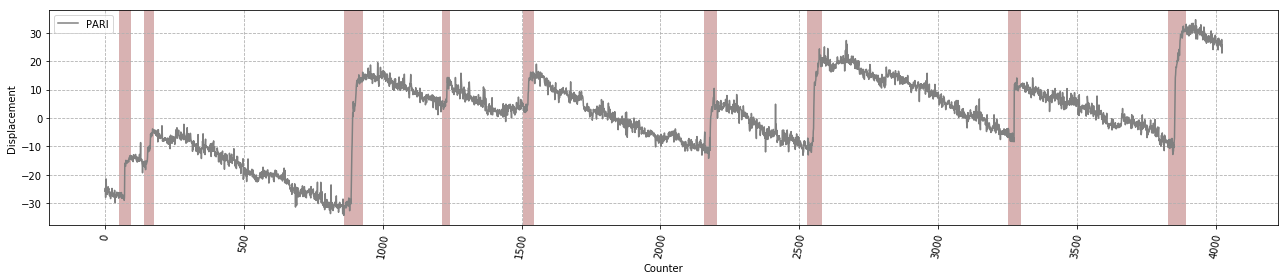

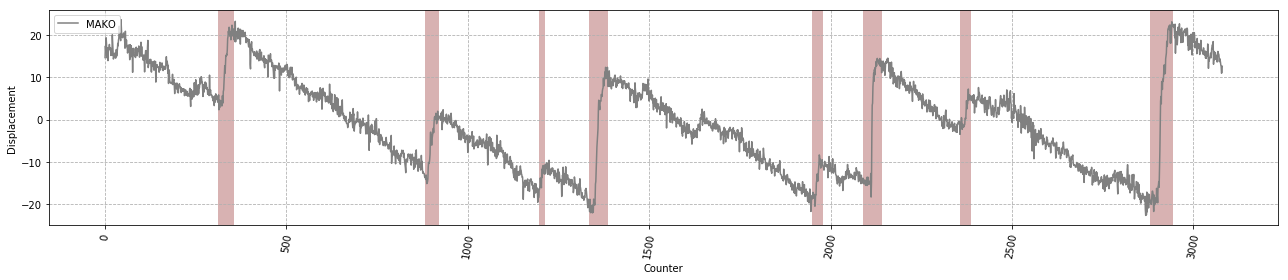

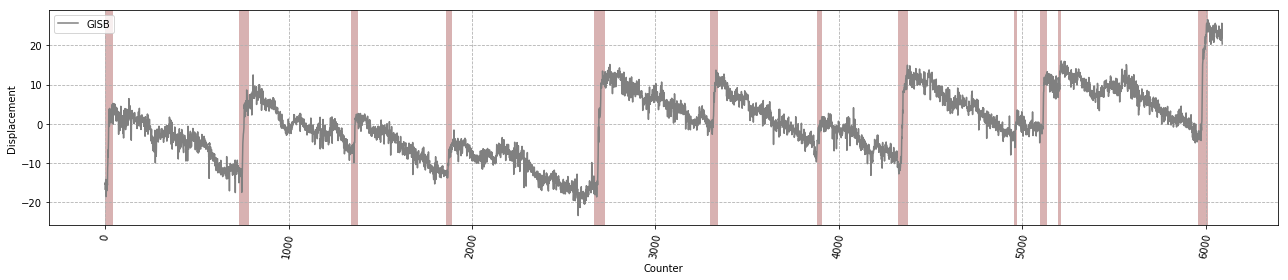

In [31]:
for i in stations_list:

    fig, ax = plt.subplots()

    plt.plot(globals()['df_{0}'.format(i)]['x'],'-', color='gray',label=i)
    plt.legend(loc=2)
    plt.xticks( rotation= 80 )

        # Grids
    plt.gca().xaxis.grid(True, linestyle='--')
    plt.gca().yaxis.grid(True, linestyle='--')

    plt.xlabel('Counter')
    plt.ylabel('Displacement')
    # if (dataset_test['Events'] == 0.5): plt.axhline()

        # Get current size
    fig_size = plt.rcParams["figure.figsize"]

        # Set figure width to 18 and height to 4
    fig_size[0] = 18
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size



    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    theta = 0.5
    ax.fill_between(range(len(globals()['df_{0}'.format(i)]['Events'])), 
                    min(globals()['df_{0}'.format(i)]['Events']), 
                    max(globals()['df_{0}'.format(i)]['Events']), 
                    where=(globals()['df_{0}'.format(i)]['Events'] > 0.5), 
                    facecolor='maroon',
                    alpha=0.3, transform=trans) 

    # plt.show()

    plt.tight_layout()
    plt.plot()

In [32]:
input_X_MAHI = df_MAHI.loc[:, df_MAHI.columns != 'Events'].values  # converts the df to a numpy array
input_X_PARI = df_PARI.loc[:, df_PARI.columns != 'Events'].values
input_X_MAKO = df_MAKO.loc[:, df_MAKO.columns != 'Events'].values
input_X_GISB = df_GISB.loc[:, df_GISB.columns != 'Events'].values




input_y_MAHI = df_MAHI['Events'].values
input_y_PARI = df_PARI['Events'].values
input_y_MAKO = df_MAKO['Events'].values
input_y_GISB = df_GISB['Events'].values

n_features_MAHI = 3  # number of features

print(input_X_MAHI.shape,input_y_MAHI.shape)

(4330, 3) (4330,)


In [33]:
def temporalize(X, y, lookback, input_X, input_y):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return np.array(X), np.array(y)

In [34]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

# 40 Days windows shifted - Standarize

In [35]:
# Temporalize the data

lookback = 20
X_1_MAHI, y_mahi = temporalize(X = input_X_MAHI, y = input_y_MAHI, lookback = lookback,input_X = input_X_MAHI,input_y = input_y_MAHI)

X_mahi = X_1_MAHI.reshape(X_1_MAHI.shape[0], lookback, n_features_MAHI)

# lookback = 20
# X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

# X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

# lookback = 20
# X_1_GISB, y_gisb = temporalize(X = input_X_GISB, y = input_y_GISB, lookback = lookback, input_X = input_X_GISB, input_y = input_y_GISB)

# X_gisb = X_1_GISB.reshape(X_1_GISB.shape[0], lookback, 3)

In [36]:
print(X_mahi.shape,y_mahi.shape)

# print(X_pari.shape,y_pari.shape)

(4309, 20, 3) (4309,)


In [37]:
# load model
model = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days-shifted.h5")
# summarize model.
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


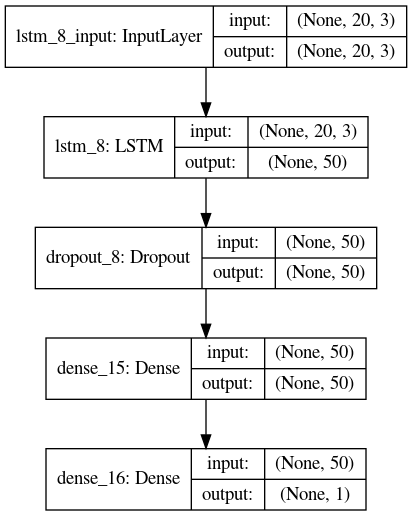

In [38]:
# %load_ext tensorboard
# %tensorboard --logdir {logs_base_dir}
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
y_pred_shift = model.predict_classes(X_mahi)

y_pred_shift_prob = model.predict(X_mahi)

In [40]:
y_pred_shift.shape

(4309, 1)

In [41]:
df_xarray = df_MAHI['x'].iloc[20:]


In [42]:
df_result = pd.DataFrame(data=[df_xarray.values,y_pred_shift_prob]).T
df_result.columns = ['x','Events']

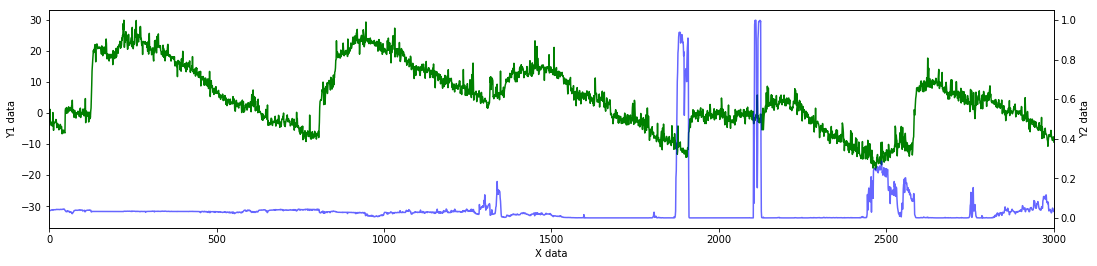

In [43]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# plt.axhline(y=0.08, color='r', linestyle='-')

ax1.set_xlim(0,3000)
ax2.set_xlim(0,3000)

plt.show()

In [44]:
# transform probabilities


df_result['prob'] = [1. if e > 0.1 else 0. for e in df_result.Events.values]

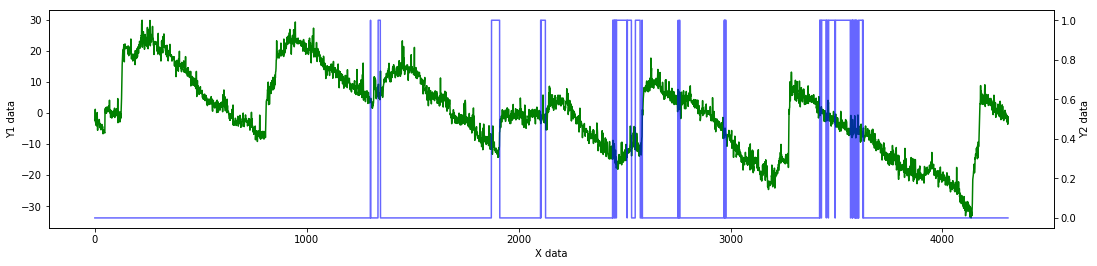

In [45]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['prob'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# plt.axhline(y=0.08, color='r', linestyle='-')

# ax1.set_xlim(0,3000)
# ax2.set_xlim(0,3000)


plt.show()


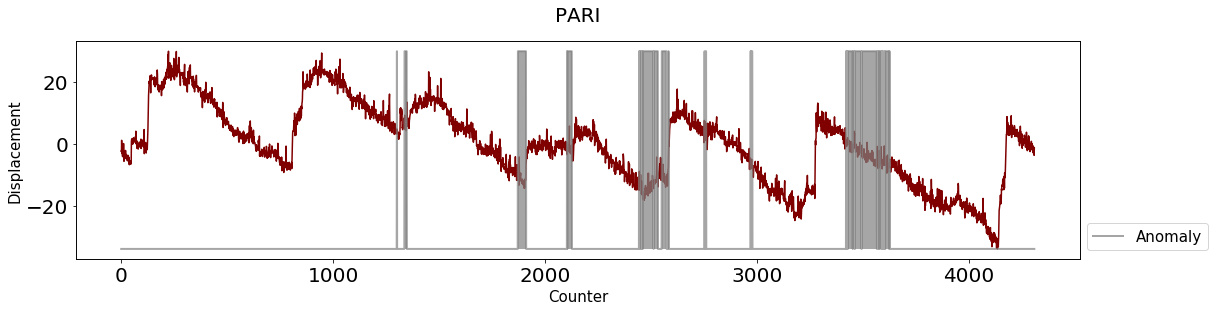

In [46]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], '-',color='maroon')
ax2.plot( df_result['prob'], '-',color='gray',alpha=0.7,linewidth=2,label='Anomaly')


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result.index, 0, 1, where=df_result['prob'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('PARI',fontsize=20, ha="center",pad=20)

# ax1.set_xlim(0,3000)
# ax2.set_xlim(0,3000)


plt.show()

/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


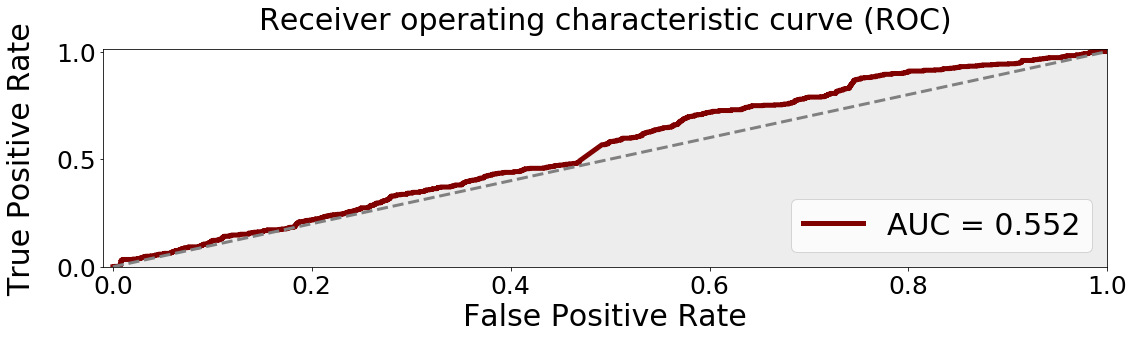

In [48]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_mahi, y_pred_shift_prob)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc,color='maroon')
plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=30)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()

# Autoencoder Test

Best performance Autoencoder 40 days window - standarize- 128 layer


In [175]:
lookback = 40
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)


lookback = 40
X_1_MAHI, y_mahi = temporalize(X = input_X_MAHI, y = input_y_MAHI, lookback = lookback,input_X = input_X_MAHI,input_y = input_y_MAHI)

X_mahi = X_1_MAHI.reshape(X_1_MAHI.shape[0], lookback, n_features_MAHI)

In [176]:
# load model
# learning_rate = 0.0001
model = load_model("/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder-classifier_LSTM_SSE_40window-stand.h5")
# model = load_model("/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder_LSTM_SSE_40shifted-stand.h5")
# summarize model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 40, 128)           67584     
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 40, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_28 (LSTM)               (None, 40, 128)           98816     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 40, 3)             387       
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
________________________________________________

In [177]:
# Initialize a scaler using the training data.

# scaler = StandardScaler().fit(flatten(X_pari))

scaler = StandardScaler().fit(flatten(X_mahi))

In [178]:
# Standarize the input


# X_pari_scaled = scale(X_pari, scaler)


X_mahi_scaled = scale(X_mahi, scaler)


In [179]:
# test_x_predictions = model.predict(X_pari_scaled)


test_x_predictions = model.predict(X_mahi_scaled)

# test_x_predictions = model.predict(X_pari)

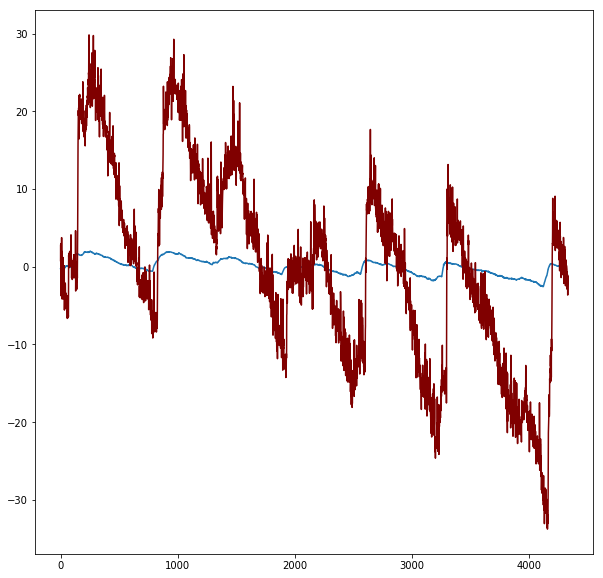

In [180]:
plt.plot(flatten(test_x_predictions)[:,[0]])

# plt.plot(flatten(test_x_predictions)[:,[2]])

# plt.plot(df_PARI['x'].values,color='maroon')

plt.plot(df_MAHI['x'].values,color='maroon')
# plt.title("PARI")
# plt.ylabel("Displacement")
# plt.xlabel("Data point index")
# plt.show();
# flatten(test_x_predictions)[1]

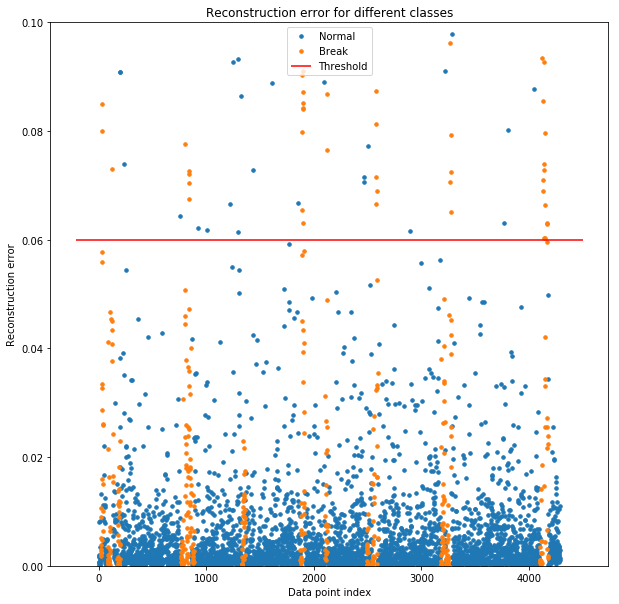

In [181]:
# mse = np.mean(np.power(flatten(X_pari_scaled) - flatten(test_x_predictions), 2), axis=1)
mse = np.mean(np.power(flatten(X_mahi_scaled) - flatten(test_x_predictions), 2), axis=1)
# mse = np.mean(np.power(flatten(X_pari) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_mahi.tolist()})

threshold_fixed = 0.06 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.ylim(0,0.1)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [182]:
pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

<Figure size 720x720 with 0 Axes>

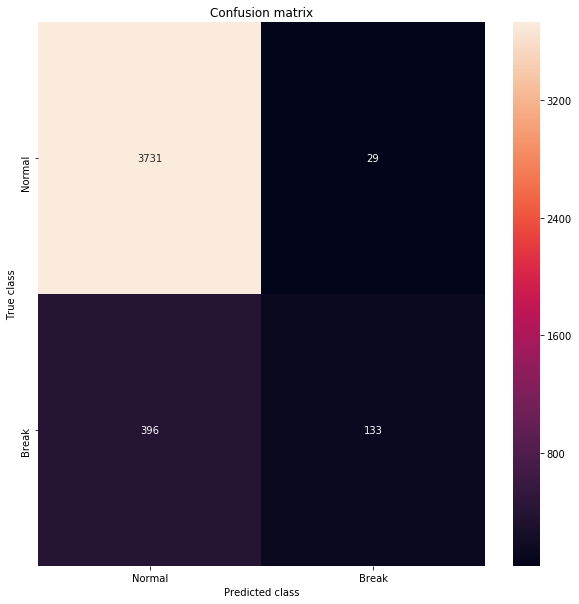

In [183]:
conf_matrix = confusion_matrix(error_df.True_class,pred_y)

plt.figure(figsize=(10, 10))
# Normalise
cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")

# ax = sns.heatmap(cmn, xticklabels=LABELS, yticklabels=LABELS, annot=True)




plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

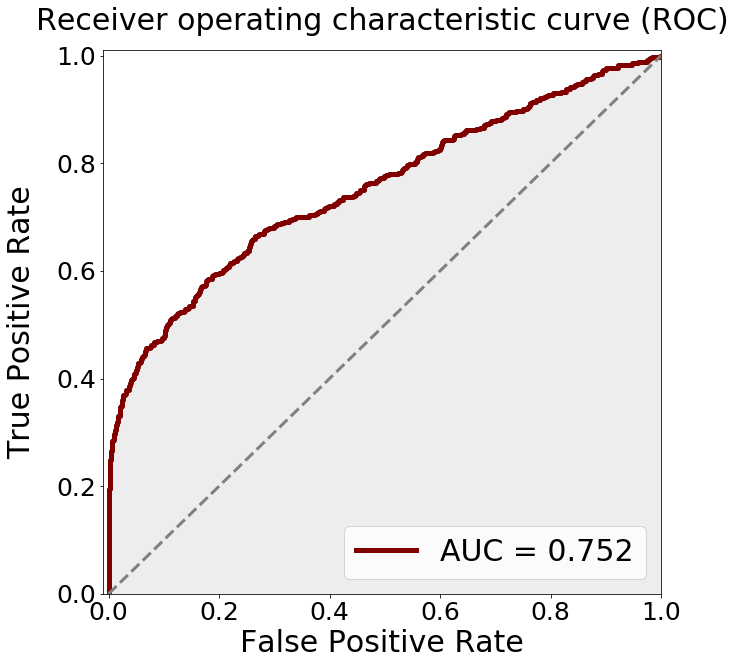

In [323]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc,color='maroon')
plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=30)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()

In [185]:
df_xarray = df_MAHI['x'].iloc[20:]


In [186]:
df_result = pd.DataFrame(data=[df_xarray.values,pred_y]).T
df_result.columns = ['x','Events']

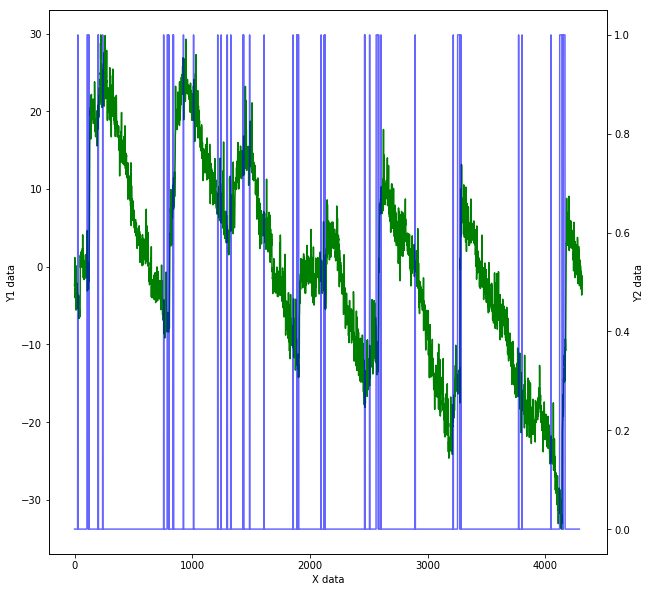

In [187]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 27
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [188]:
# evaluate the model
scores = model.evaluate(X_pari,X_pari)
print((scores[1]*100))

3984/3984 [==============================] - 9s 2ms/step
44.006022810935974


[]

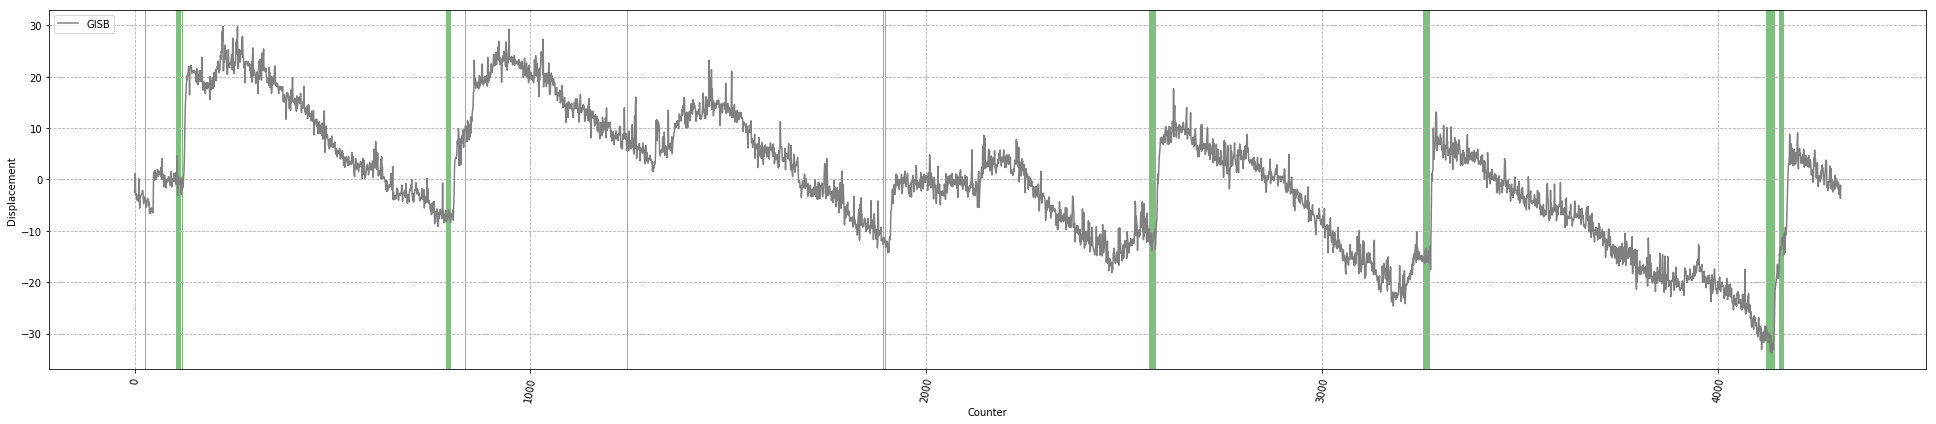

In [189]:
fig, ax = plt.subplots()

plt.plot(df_result['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result['Events'])), min(df_result['Events']), max(df_result['Events']), 
                where=(df_result['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()


# THe best of the Vanilla Model

40- days 


In [190]:
lookback = 40
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

In [191]:
lookback = 40
X_1_MAHI, y_mahi = temporalize(X = input_X_MAHI, y = input_y_MAHI, lookback = lookback,input_X = input_X_MAHI,input_y = input_y_MAHI)

X_mahi = X_1_MAHI.reshape(X_1_MAHI.shape[0], lookback, n_features_MAHI)


In [192]:
# load model
model_40 = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days.h5")

# summarize model.
model_40.summary()


# evaluate the model
scores = model_40.evaluate(X_mahi,y_mahi)
print((scores[1]*100)) 


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________
4289/4289 [==============================] - 3s 639us/step
92.56237149238586


In [193]:
# y_pred_40 = model_40.predict_classes(X_pari)

# y_pred_40_prob = model_40.predict(X_pari)

y_pred_40 = model_40.predict_classes(X_mahi)

y_pred_40_prob = model_40.predict(X_mahi)

In [194]:
# evaluate the model
scores = model_40.evaluate(X_mahi,y_mahi)
print((scores[1]*100))

# evaluate the mode
# scores = model_40.evaluate(X_pari,y_pari)
# print((scores[1]*100))

4289/4289 [==============================] - 2s 470us/step
92.56237149238586


<Figure size 720x720 with 0 Axes>

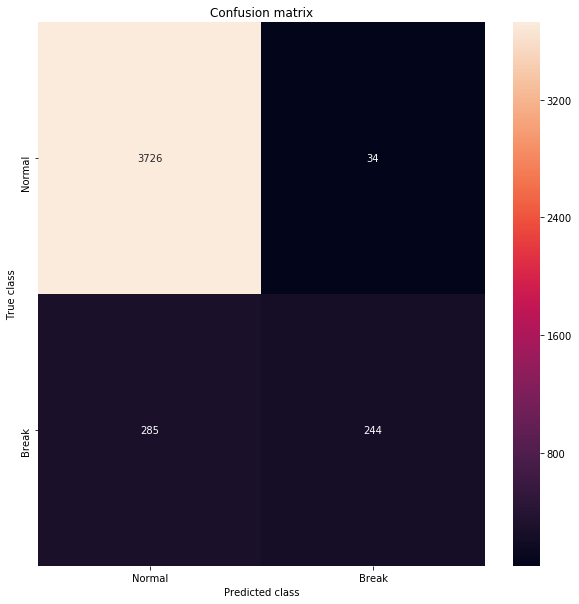

In [195]:
# conf_matrix = confusion_matrix(y_pari.astype(int), y_pred_40)
conf_matrix = confusion_matrix(y_mahi.astype(int), y_pred_40)
# conf_matrix = confusion_matrix( y_pred_40,y_pari.astype(int))


plt.figure(figsize=(10, 10))
# Normalise
cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

# ax = sns.heatmap(cmn, xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

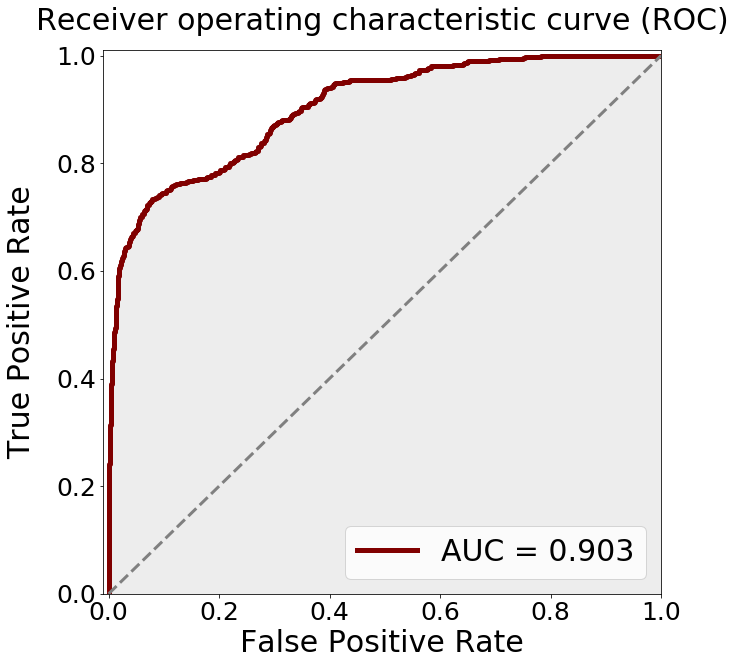

In [218]:
# false_pos_rate, true_pos_rate, thresholds = roc_curve(y_pari, y_pred_40_prob)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_mahi, y_pred_40_prob)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc,color='maroon')
plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=30)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()

In [197]:
# df_xarray_40 = df_PARI['x'].iloc[40:]
# df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
# df_result_40.columns = ['x','Events']


df_xarray_40 = df_MAHI['x'].iloc[40:]
df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
df_result_40.columns = ['x','Events']

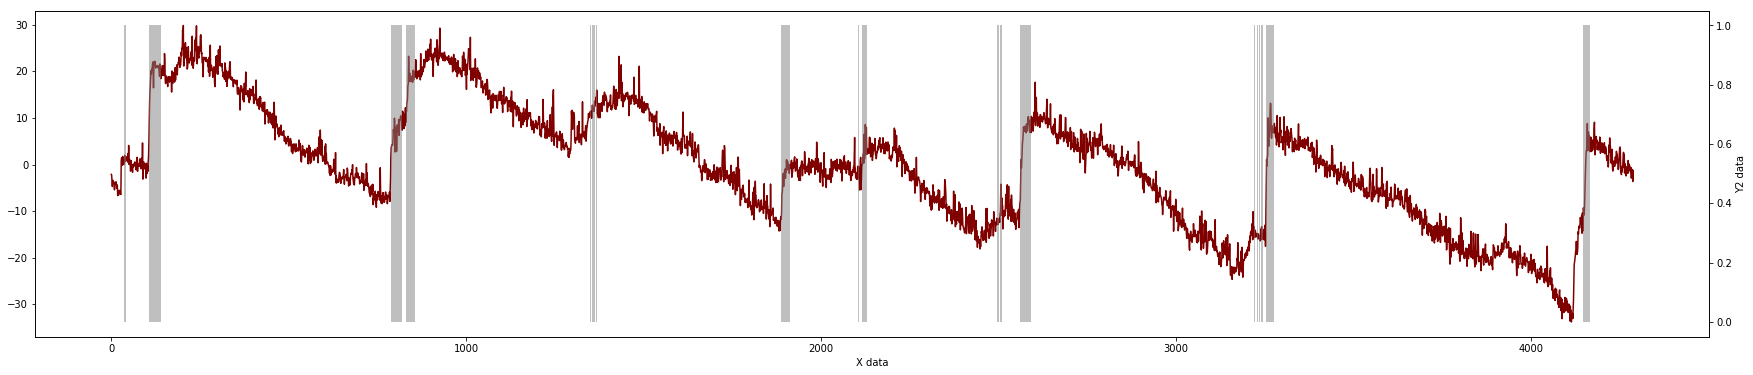

In [216]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40['x'], '-',color='maroon')
# ax2.plot( df_result_40['Events'], '-',color='gray',alpha=0.6)

ax1.set_xlabel('X data')
# ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_40.index, 0, 1, where=df_result_40['Events'] > 0.5,
                facecolor='gray', alpha=0.5
                )

plt.show()

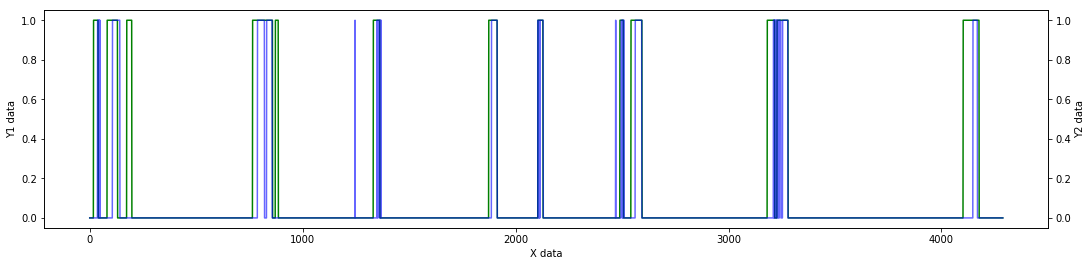

In [199]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( y_mahi, 'g-')
ax2.plot( y_pred_40
         , 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

[]

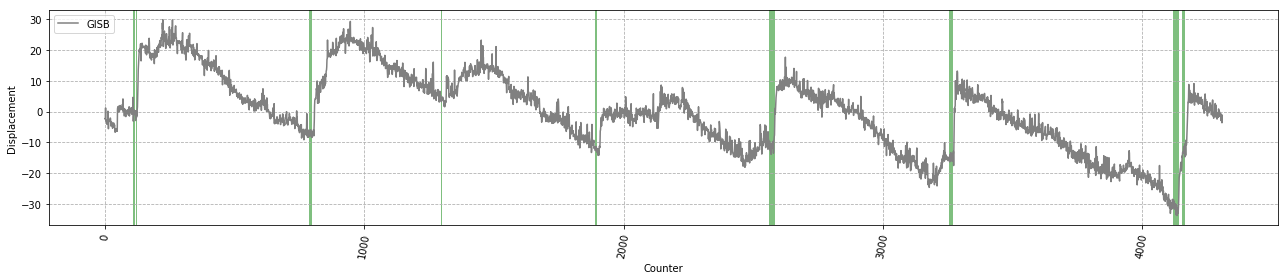

In [200]:
fig, ax = plt.subplots()

plt.plot(df_result['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result['Events'])), min(df_result['Events']), max(df_result['Events']), 
                where=(df_result['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

In [201]:
np.count_nonzero(y_pred_40 == 1)

278

In [202]:
np.count_nonzero(y_mahi == 1)

529

# Autoencoder with shift

In [280]:
lookback = 20
X_1_PARI, y_pari = temporalize(X = input_X_PARI, y = input_y_PARI, lookback = lookback, input_X = input_X_PARI, input_y = input_y_PARI)

X_pari = X_1_PARI.reshape(X_1_PARI.shape[0], lookback, 3)

In [281]:
# load model
# learning_rate = 0.0001
# model = load_model("/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder-classifier_LSTM_SSE_40window-stand.h5")
model = load_model("/home/francovm/Projects/SSE/models/Autoencoder/Autoencoder_LSTM_SSE_40shifted-stand.h5")
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 32)            4608      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3)             99        
Total params: 16,227
Trainable params: 16,227
Non-trainable params: 0
__________________________________________________

In [282]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_pari))

In [283]:
# Standarize the input
X_pari_scaled = scale(X_pari, scaler)


In [284]:
test_x_predictions = model.predict(X_pari_scaled)
# test_x_predictions = model.predict(X_pari)

(0, 3000)

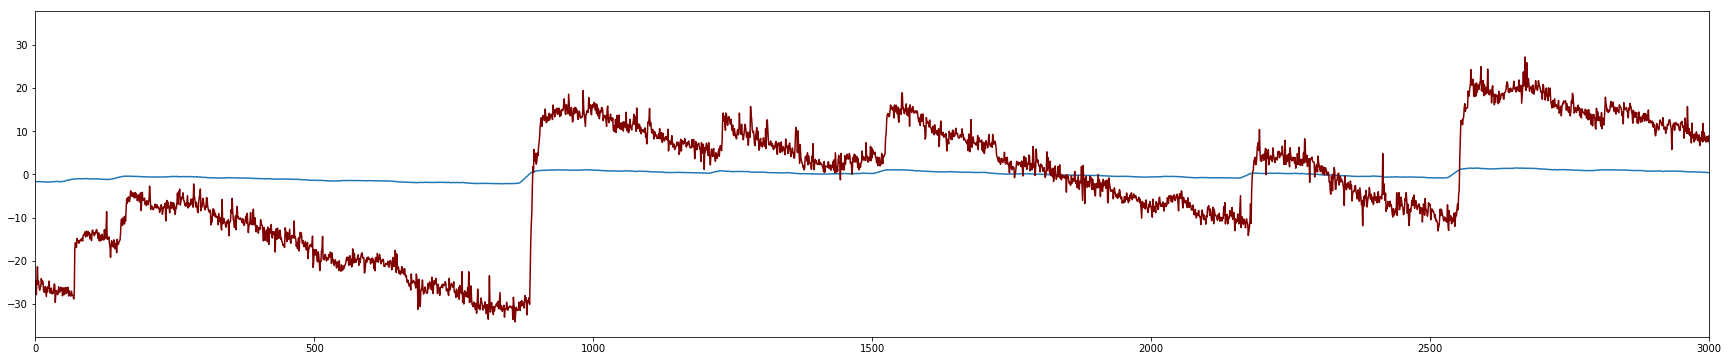

In [294]:
plt.plot(flatten(test_x_predictions)[:,[0]])

# plt.plot(flatten(test_x_predictions)[:,[2]])
plt.plot(df_PARI['x'].values,color='maroon')
# plt.title("PARI")
# plt.ylabel("Displacement")
# plt.xlabel("Data point index")
# plt.show();
plt.xlim(0,3000)
# flatten(test_x_predictions)[1]

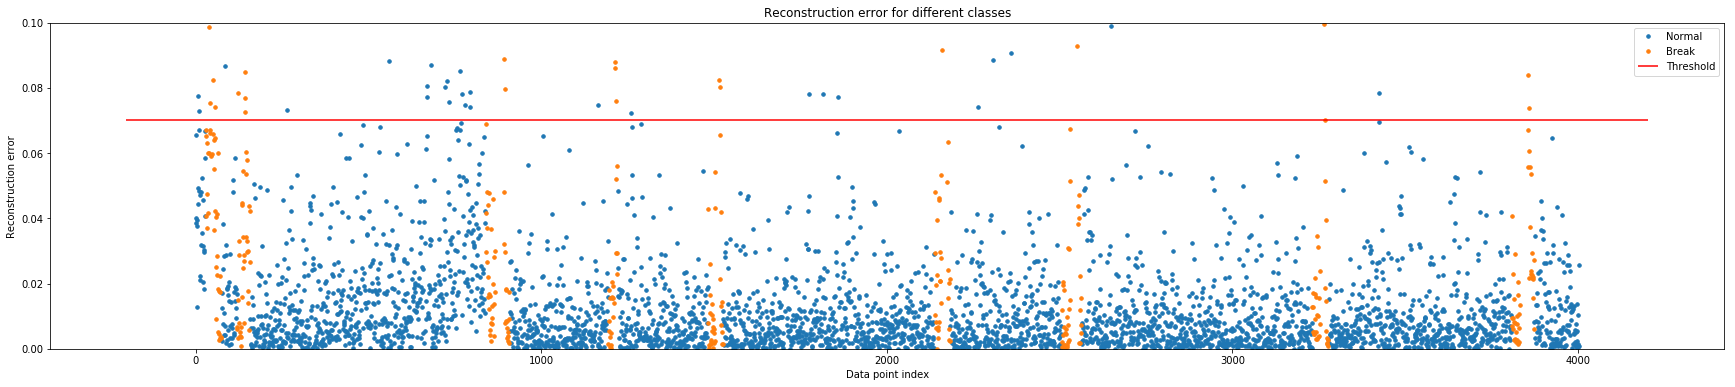

In [286]:
mse = np.mean(np.power(flatten(X_pari_scaled) - flatten(test_x_predictions), 2), axis=1)
# mse = np.mean(np.power(flatten(X_pari) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_pari.tolist()})

threshold_fixed = 0.07 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.ylim(0,0.1)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [287]:
pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

<Figure size 720x720 with 0 Axes>

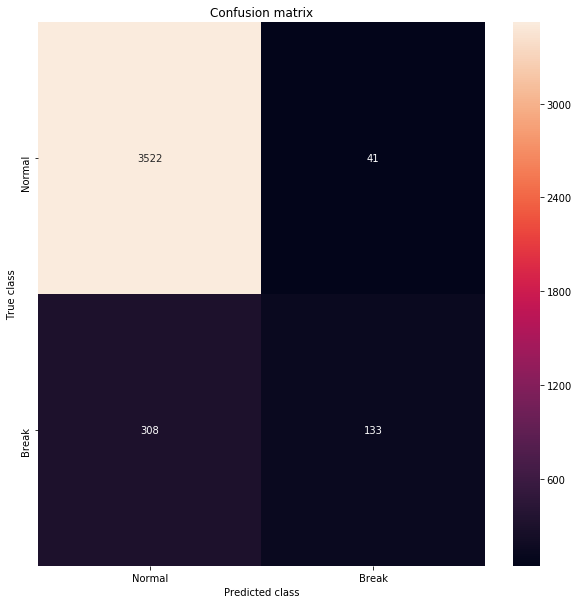

In [288]:
conf_matrix = confusion_matrix(error_df.True_class,pred_y)

plt.figure(figsize=(10, 10))
# Normalise
cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")

# ax = sns.heatmap(cmn, xticklabels=LABELS, yticklabels=LABELS, annot=True)




plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()

/home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


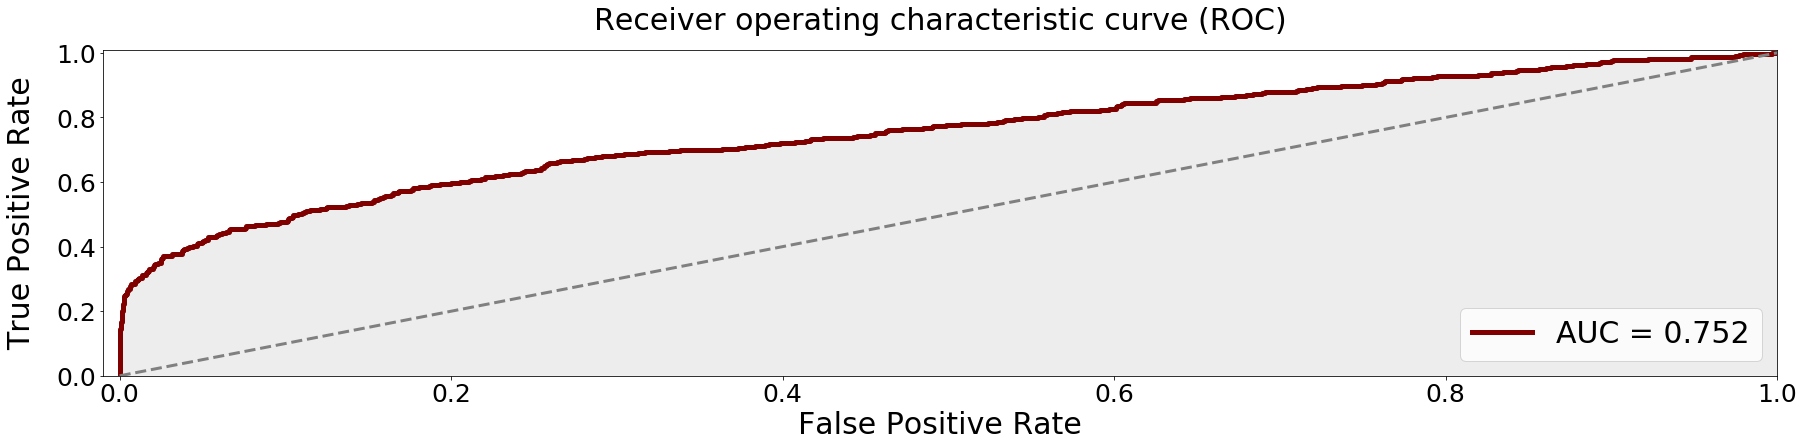

In [289]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc,color='maroon')
plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=30)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()

In [290]:
df_xarray = df_PARI['x'].iloc[20:]


In [291]:
df_result = pd.DataFrame(data=[df_xarray.values,pred_y]).T
df_result.columns = ['x','Events']

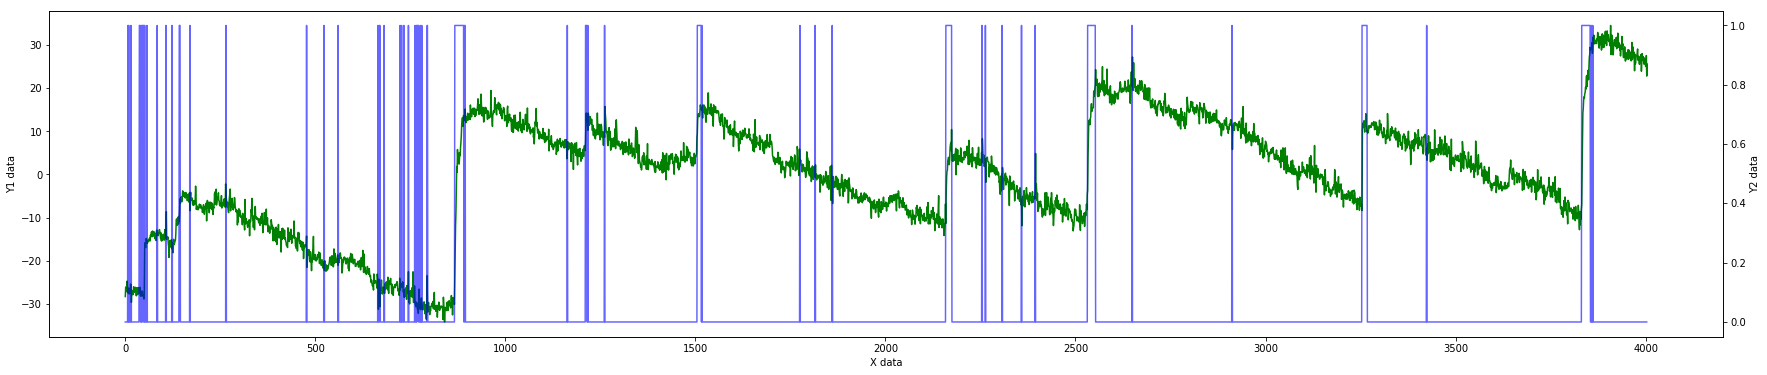

In [293]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result['x'], 'g-')
ax2.plot( df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 30
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size


plt.show()